# Stress Intensity Factor in 2D Griffith Crack

In [38]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors

from scipy.sparse.linalg import gmres

np.set_printoptions(precision=5, suppress=True)

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [4, 3.5]
plt.rcParams['font.size'] = 15
plt.rcParams['text.usetex']=True
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["text.latex.preamble"] =r'\usepackage{amsmath}'+ r'\usepackage{amssymb}' + r'\usepackage{accents}'+ r'\usepackage{bm}'+ r'\boldmath'+ r'\renewcommand{\v}[1]{\boldsymbol{{#1}}}'+ r'\DeclareRobustCommand{\sot}[1]{\boldsymbol{{#1}}}'

norm1 = lambda a : np.linalg.norm(a, axis=1)
norm = lambda a : np.linalg.norm(a)

home = os.environ['HOME']

#change to the approprite bigwham directory and remember to place your notebook outside bigwham dir
sys.path.append(home + "/Desktop/GEL/BigWham/build/interfaces/python")
from hmatrix import Hmatrix  # linear operator file
os.environ["OMP_NUM_THREADS"] = "4"

In [39]:
pressure = 1.0

G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)

alpha = 1 - nu
pre_fac = (2*alpha*pressure)/G

# Mesh
a = 1.0
nelts = 100
coor1D = np.linspace(-a, a, nelts + 1)
coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)

# H-matrix parameter
max_leaf_size=100
eta=3.
eps_aca=1.e-4

# Hmatrix
kernel = "2DP0"
elas_prop = np.array([E, nu])
hmat = Hmatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)

col_pts = hmat.getMeshCollocationPoints()

 Now setting things for kernel ... 2DP0 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  1.095e-06
Binary cluster tree depth = 0
Number of blocks = 1
Number of full blocks = 1
Number of low rank blocks = 0
Pattern Created 
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.0083114
Compression ratio - 1
Hmat object - built 
HMAT --> built 
HMAT set, CR = 1, eps_aca = 0.0001, eta = 3
BigWhamIO ENDED


In [40]:
trac = np.zeros(col_pts.shape)
trac[:, 1] = pressure

print("Number of OMP threads {}".format(os.environ["OMP_NUM_THREADS"]))

u, info = gmres(hmat, hmat.convert_to_local(trac.flatten()))
dd_calc = hmat.convert_to_global(u)

Number of OMP threads 4


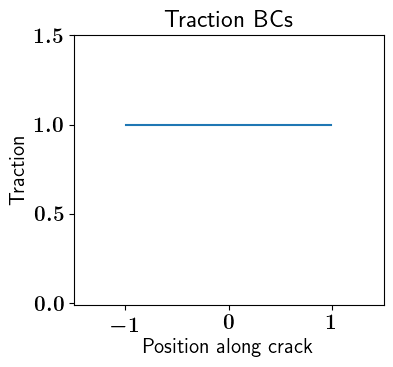

In [41]:
plt.plot(col_pts[:, 0], trac[:, 1])
plt.title("Traction BCs")
plt.xlabel("Position along crack")
plt.ylabel("Traction")
plt.xlim([-1.5, 1.5])
plt.ylim([-.01, 1.5])
plt.show()

In [42]:
dd = np.zeros(col_pts.shape)
dd[:, 1] = pre_fac*np.sqrt(a**2 - col_pts[:, 0]**2)
print(pre_fac)

1.5


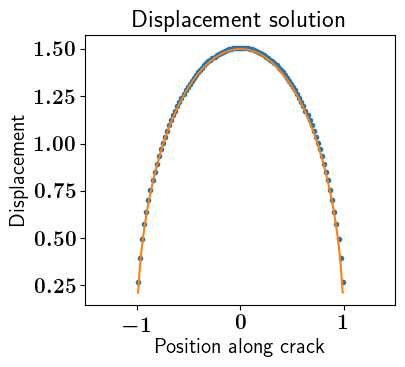

In [43]:
plt.figure()
#plt.plot(np.linalg.norm(col_pts, axis=1), dd_calc.reshape(-1, 2), ".k")
plt.title("Displacement solution")
plt.xlabel("Position along crack")
plt.ylabel("Displacement")
plt.xlim([-1.5, 1.5])
#plt.ylim([-0.1, 1.6])
plt.plot(col_pts[:, 0], dd_calc.reshape(-1, 2)[:, 1], ".")
plt.plot(col_pts[:, 0], dd[:, 1])
#plt.legend(["Numerical", "Analytical"])

In [44]:
rel_err = np.linalg.norm(dd.flatten() - dd_calc) / dd.shape[0]
print("L2 Rel error {}".format(rel_err))

L2 Rel error 0.001375101583671952


In [45]:
#K_I = (pressure*np.sqrt(np.pi*a)*4*alpha)/(G*np.sqrt(2*np.pi))
K_I = pressure*np.sqrt(np.pi*a)

print(K_I)
print(K_I**2)

1.7724538509055159
3.1415926535897927


In [46]:
sif_frac = 0.2
sif_range = int(sif_frac*len(dd)) # needs to be some fraction of the half length

#col_pts[:, 0], dd_calc.reshape(-1, 2)[:, 1]
dd_sq = dd_calc.reshape(-1, 2)[:, 1]**2

dd_sq_sif = dd_sq[:sif_range]
col_sif = col_pts[:, 0][:sif_range]

coef = np.polyfit(col_sif, dd_sq_sif, 1)

print(coef)
K_numerical = (np.sqrt(coef[1])*(G*np.sqrt(2*np.pi)))/(4*alpha)

print("Calculated K = ", K_numerical)
print("Deviation from analytical SIF = ", K_numerical - K_I)
print("Relative error = ", abs((K_numerical - K_I)/K_I))

[3.59581 3.6798 ]
Calculated K =  1.6028044623870406
Deviation from analytical SIF =  -0.16964938851847533
Relative error =  0.09571441785737012


Text(0, 0.5, 'Square of displacements')

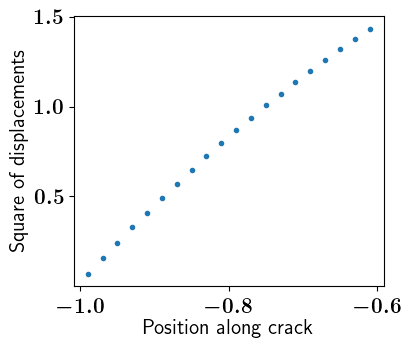

In [47]:
#print(dd_sq_sif)
plt.plot(col_sif, dd_sq_sif,'.')

plt.xlabel("Position along crack")
plt.ylabel("Square of displacements")

#plt.plot(col_pts[:, 0], dd.reshape(-1, 2)[:, 1])
#plt.plot(dd, '.')

Text(0, 0.5, 'Square of displacements')

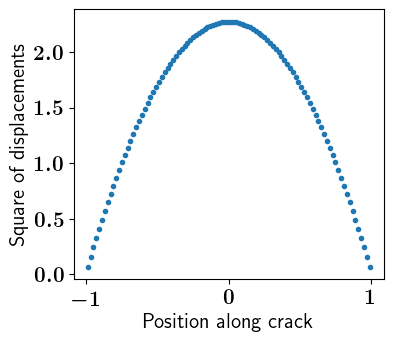

In [48]:
#print(dd_sq_sif)
plt.plot(col_pts[:, 0], dd_sq,'.')

plt.xlabel("Position along crack")
plt.ylabel("Square of displacements")

#plt.plot(col_pts[:, 0], dd.reshape(-1, 2)[:, 1])
#plt.plot(dd, '.')

/home/ratul/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


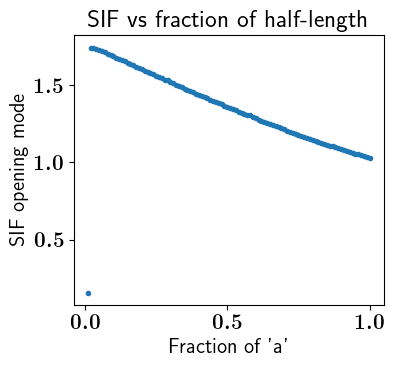

In [52]:
sif_frac_list = []
sif_list = []
rel_err_list = []

for i in range(100):
    sif_frac = 0.01*(i+1)
    sif_frac_list.append(sif_frac)
    sif_range = int(sif_frac*len(dd)) # needs to be some fraction of the half length

    #col_pts[:, 0], dd_calc.reshape(-1, 2)[:, 1]
    dd_sq = dd_calc.reshape(-1, 2)[:, 1]**2

    dd_sq_sif = dd_sq[:sif_range]
    col_sif = col_pts[:, 0][:sif_range]

    coef = np.polyfit(col_sif, dd_sq_sif, 1)

    K_numerical = (np.sqrt(coef[1])*(G*np.sqrt(2*np.pi)))/(4*alpha)
    sif_list.append(K_numerical)
    rel_error = abs((K_numerical - K_I)/K_I)
    rel_err_list.append(rel_error)

    #print("Calculated K =", K_numerical, "when", sif_range, "/", len(dd), "elements are taken")
    #print("Deviation from analytical SIF = ", K_numerical - K_I)
    #print("Relative error = ", rel_error)

plt.figure()
plt.plot(sif_frac_list, sif_list, '.')
plt.title("SIF vs fraction of half-length")
plt.xlabel("Fraction of 'a'")
plt.ylabel("SIF opening mode")
#saves fig - remember to remove
#plt.savefig('rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

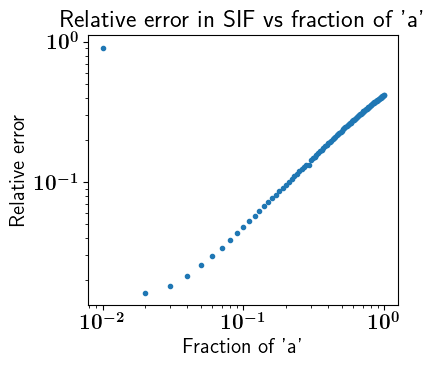

In [50]:
plt.figure()
plt.plot(sif_frac_list, rel_err_list, '.')
plt.title("Relative error in SIF vs fraction of 'a'")

plt.xlabel("Fraction of 'a'")
plt.ylabel("Relative error")

plt.yscale('log')
plt.xscale('log')

#saves fig - remember to remove
#plt.savefig('rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

In [51]:
sif_frac = 0.05
sif_range = int(sif_frac*len(dd)) # needs to be some fraction of the half length

#col_pts[:, 0], dd_calc.reshape(-1, 2)[:, 1]
dd_sq = dd_calc.reshape(-1, 2)[:, 1]**2

dd_sq_sif = dd_sq[:sif_range]
col_sif = col_pts[:, 0][:sif_range]

coef = np.polyfit(col_sif, dd_sq_sif, 1)

print(coef)
K_numerical = (np.sqrt(coef[1])*(G*np.sqrt(2*np.pi)))/(4*alpha)

print("Calculated K = ", K_numerical)
print("Deviation from analytical SIF = ", K_numerical - K_I)
print("Relative error = ", abs((K_numerical - K_I)/K_I))

[4.24484 4.27413]
Calculated K =  1.72739800529646
Deviation from analytical SIF =  -0.045055845609055956
Relative error =  0.025420038770565284
